# 1 Python Libraries

## 1.1 Installations

In [23]:
#pip install pandas

In [24]:
#pip install inflection

In [25]:
#pip install seaborn

## 1.2 Imports

In [86]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
from datetime import datetime
from datetime import timedelta

## 1.3 Settings

In [27]:
# Suprimir notação científica no Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
matplotlib.rcParams['figure.figsize'] = (16, 8)
sns.set_style("darkgrid")

# 2 Data Extraction

## 2.1 Data Load

In [28]:
df_sales_raw = pd.read_csv('../dados/rossmann-store-sales/train.csv')
df_store_raw = pd.read_csv('../dados/rossmann-store-sales/store.csv')

/home/mg/Documents/data_science_em_producao/dsproducao/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
#df_sales_raw.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [30]:
#df_store_raw.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"


In [31]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='inner', on='Store')

In [32]:
#df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
239677,264,7,2013-12-29,0,0,0,0,0,0,a,a,180.00,3.00,2014.00,0,NaN,NaN,NaN


# 3 Transformations

In [33]:
df1 = df_raw.copy()

## 3.1 Rename Columns

In [34]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
                     'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
                     'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                     'Promo2SinceYear', 'PromoInterval']
# Renomeando as colunas para o padrão snacke case
snackecase = lambda x: inflection.underscore(x)
cols_new = list(map(snackecase, cols_old))
df1.columns = cols_new

## 3.2 Dimensions

In [35]:
#print(f'Number of rows: {df1.shape[0]}')
#print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 3.3 Types

In [36]:
df1['date'] = pd.to_datetime(df1['date'])
#df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 3.4 Missing

In [37]:
#df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 3.5 Fill NaN

### competition_distance              

Representa a distância do concorrente mais próximo

Suposição: 
1. Não possuem concorrentes próximos; 
2. A distância com relação ao concorrente é muito longa.

Tratamento: 
1. Preencher as linhas com um registro maior do que a distância máxima registrada na coluna.

In [38]:
#print(f"Maior distância do concorrente para a loja: {df1['competition_distance'].max()}")
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#print(f"Dados NaN restantes: {df1['competition_distance'].isna().sum()}")                 

Maior distância do concorrente para a loja: 75860.0
Dados NaN restantes: 0


### competition_open_since_month

Representa aproximadamente o mês que o concorrente mais próximo abriu a loja

Suposição: 
1. Falta do concorrente próximo;
2. O concorrente próximo abriu a loja antes;
3. A data de abertura do concorrente não foi registrada. 

Tratamento:
1. Extrair da coluna date o mês da data da venda, por considerar que as vendas são influenciadas pela data no qual o concorrente próximo abriu. 

In [39]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [40]:
#print(f'Dados faltantes na coluna: {df1["competition_open_since_month"].isna().sum()}')

Dados faltantes na coluna: 0


### competition_open_since_year

Representa aproximadamente o ano que o concorrente mais próximo abriu a loja

Suposição: 
1. Falta do concorrente próximo;
2. O concorrente próximo abriu a loja antes;
3. A data de abertura do concorrente não foi registrada. 

Tratamento:
1. Extrair da coluna date o ano da data da venda, por considerar que as vendas são influenciadas pela data no qual o concorrente próximo abriu. 

In [41]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [42]:
#print(f'Dados faltantes na coluna: {df1["competition_open_since_year"].isna().sum()}')

Dados faltantes na coluna: 0


### promo2_since_week

In [43]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [44]:
#print(f'Dados faltantes na coluna: {df1["promo2_since_week"].isna().sum()}')

Dados faltantes na coluna: 0


### promo2_since_year 

In [45]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [46]:
#print(f'Dados faltantes na coluna: {df1["promo2_since_year"].isna().sum()}')

Dados faltantes na coluna: 0


### promo_interval

In [47]:
month_map = {1: 'Jan',
            2: 'Feb',
            3: 'Mar',
            4: 'Apr',
            5: 'May',
            6: 'Jun',
            7: 'Jul',
            8: 'Aug',
            9: 'Sep',
            10: 'Oct',
            11: 'Nov',
            12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [48]:
#print(f'Dados faltantes na coluna: {df1["promo_interval"].isna().sum()}')

Dados faltantes na coluna: 0


## 3.6 Change Data Types

In [49]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
#df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 3.7 Descriptive Statistical

In [50]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 3.7.1 Numerical Attribues

In [51]:
# Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean))
ct2 = pd.DataFrame(num_attributes.apply(np.median))

# Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame((num_attributes).apply(np.std))
d2 = pd.DataFrame(num_attributes).apply(min)
d3 = pd.DataFrame(num_attributes).apply(max)
d4 = pd.DataFrame(num_attributes).apply(lambda x: x.max() - x.min())
d5 = pd.DataFrame(num_attributes).apply(lambda x: x.skew())
d6 = pd.DataFrame(num_attributes).apply(lambda x: x.kurtosis())

# Concatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6], axis=1).reset_index()
m.columns = ['features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
#m

,features,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


### 3.7.2 Categorical Attributes

In [52]:
#cat_attributes.apply(lambda x: x.unique().shape)

,state_holiday,store_type,assortment,promo_interval,month_map
0,5,4,3,4,12


<AxesSubplot:xlabel='assortment', ylabel='sales'>

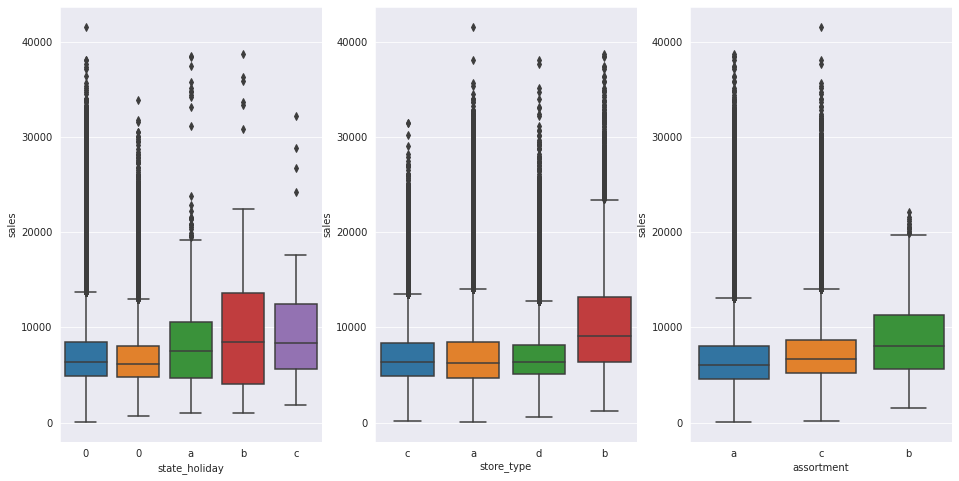

In [53]:
'''
ax1 = df1[df1['sales'] > 0]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=ax1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=ax1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=ax1)
'''

# 4 Feature Engineering

In [55]:
df2 = df1.copy()

## 4.1 Mind Map Hypothesis

Mind Map Hypothesis

Phenomenon
- Sales forecast

Agents:
- Customers, stores, time and products

Agents attributes
- Image below

Hypothesis:
- Topics below

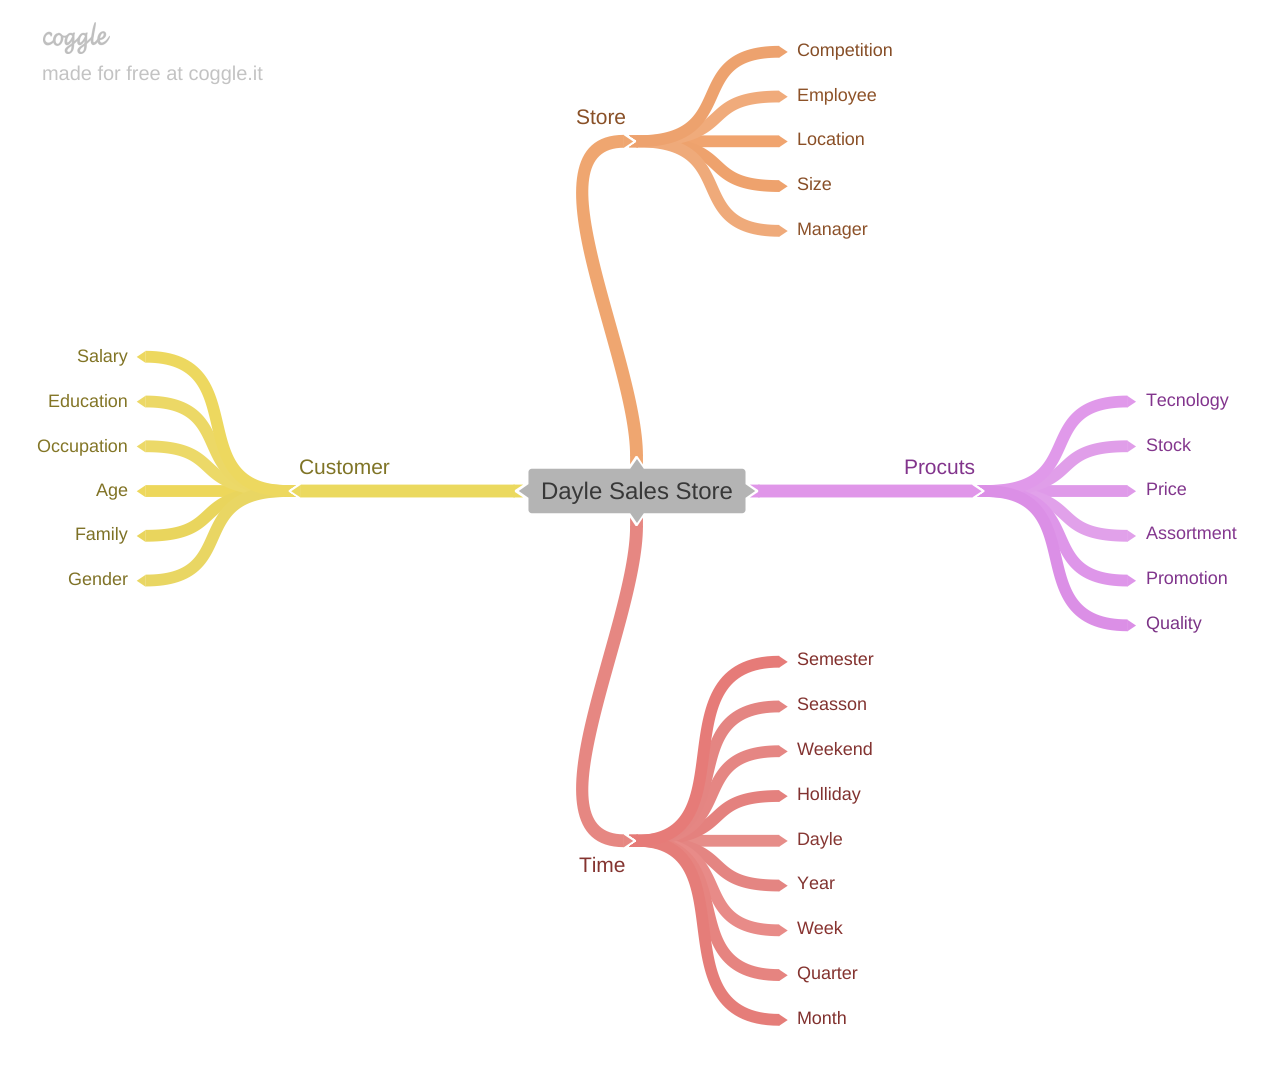

In [56]:
Image('../img/Dayle_Sales_Store.png')

### 4.1.1 Store Hyphotesis

1. Lojas maiores deveriam vender mais;

2. Lojas com mais funcionários deveriam vender mais;

3. Lojas com concorrentes por perto deveriam vender menos;

4. Lojas com maior estoque deveriam vender mais;

5. Lojas com mais produtos na vitrine deveriam vender mais;

6. Lojas com maior sortimento deveriam vender mais; 

7. Lojas com concorrentes a mais tempo deveriam vender mais;

8. Lojas com promoção ativas deveriam vender mais;

9. Lojas com promoção ativas por mais tempo deveriam vender mais;

10. Lojas com promoção consecutivas deveriam vender mais; 

### 4.1.2 Product Hyphotesis

1. Produtos mais baratos deveriam vender mais;

2. Produtos em promoção deveriam vender mais;

3. Produtos mais caros deveriam vender menos;

4. Produtos com maior qualidade deveriam vender mais;

### 4.1.3 Time Hyphotesis

1. No segundo semestre deveriam aumentar as vendas;

2. No verão as vendas deveriam ser maiores;

3. No final de semana as vendas são menores;

4. Durante as férias escolares as vendas são menores;

5. No natal as vendas são maiores; 

6. As vendas são maiores com o passar dos anos;

## 4.2 Hyphotesis List

1. Lojas com maior sortimento deveriam vender mais; 

2. Lojas com concorrentes por perto deveriam vender menos;

3. Lojas com concorrentes a mais tempo deveriam vender mais;

4. Lojas com promoção ativas deveriam vender mais;

5. Lojas com promoção ativas por mais tempo deveriam vender mais;

6. Lojas com promoção consecutivas deveriam vender mais; 

7. No natal as vendas são maiores; 

8. As vendas são maiores com o passar dos anos;

9. No segundo semestre deveriam aumentar as vendas;

10. No final de semana as vendas são menores;

11. Durante as férias escolares as vendas são menores;

12. Depois do dia 10 de cada mais as vendas deveriam ser maiores;

## 4.3 Feature Engineering

In [104]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [103]:
df2.T

,0,1,2,3,4,5,6,7,8,9,...,1017199,1017200,1017201,1017202,1017203,1017204,1017205,1017206,1017207,1017208
store,1,1,1,1,1,1,1,1,1,1,...,1115,1115,1115,1115,1115,1115,1115,1115,1115,1115
day_of_week,5,4,3,2,1,7,6,5,4,3,...,4,3,2,1,7,6,5,4,3,2
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00,2015-07-26 00:00:00,2015-07-25 00:00:00,2015-07-24 00:00:00,2015-07-23 00:00:00,2015-07-22 00:00:00,...,2013-01-10 00:00:00,2013-01-09 00:00:00,2013-01-08 00:00:00,2013-01-07 00:00:00,2013-01-06 00:00:00,2013-01-05 00:00:00,2013-01-04 00:00:00,2013-01-03 00:00:00,2013-01-02 00:00:00,2013-01-01 00:00:00
sales,5263,5020,4782,5011,6102,0,4364,3706,3769,3464,...,5007,4649,5243,6905,0,4771,4540,4297,3697,0
customers,555,546,523,560,612,0,500,459,503,463,...,339,324,341,471,0,339,326,300,305,0
open,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,0,1,1,1,1,0
promo,1,1,1,1,1,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
state_holiday,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,...,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,regulra_day,public_holiday
school_holiday,1,1,1,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
store_type,c,c,c,c,c,c,c,c,c,c,...,d,d,d,d,d,d,d,d,d,d
